In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt
import theano

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load data

In [2]:
aCH_ = np.load('aCH.npy')
aCH_ = theano.shared(np.squeeze(aCH_).T)
aCOH_ = np.load('aCOH.npy')
aCOH_ = theano.shared(np.squeeze(aCOH_).T)
sigma = np.load('sigma.npy')
Y = np.load('Y.npy')
n = aCH_.eval().shape[1]

### Indexing model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [ncomp_aCOH, ncomp_aCH]
>NUTS: [b1_interval__]
100%|██████████| 1000/1000 [00:00<00:00, 1251.74it/s]
The number of effective samples is smaller than 10% for some parameters.


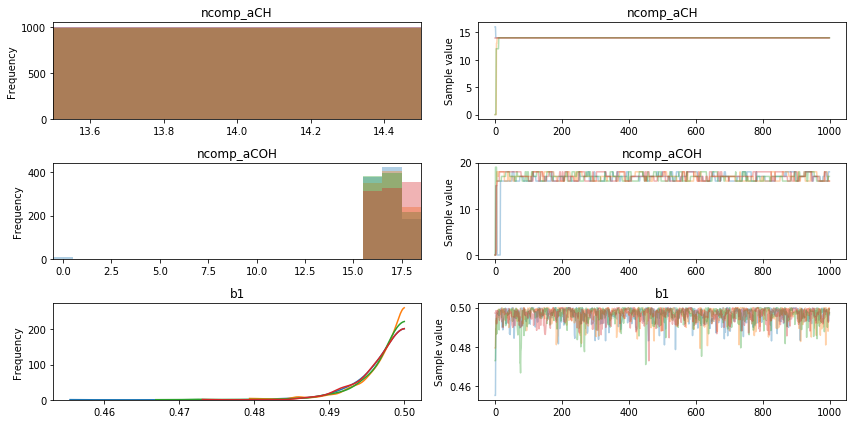

In [3]:
with pm.Model() as basic_model:
    # Priors for unknown model parameters
    b1 = pm.Uniform('b1', lower=0.3, upper=0.5, testval=0.45)
    ncomp_aCH = pm.Categorical('ncomp_aCH', p=np.ones(n)/n)
    ncomp_aCOH = pm.Categorical('ncomp_aCOH', p=np.ones(n)/n)

    aCH=aCH_[:, ncomp_aCH]
    aCOH=aCOH_[:, ncomp_aCOH]

    out= b1*aCH+aCOH

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=out, tau=sigma, observed=Y)
    trace = pm.sample(discard_tuned_samples=False)
pm.traceplot(trace);

### Diagnose problem of sampling `ncomp_aCH`

In [4]:
point = trace[-1]
point

{'b1': 0.4994031032620797,
 'b1_interval__': 5.8113395692640175,
 'ncomp_aCH': 14,
 'ncomp_aCOH': 16}

In [5]:
for i in range(n):
    point['ncomp_aCH']=i
    print(point['ncomp_aCH'], basic_model.logp(point))

0 -1111.931607170361
1 -1119.6817981084332
2 -1129.3000127919622
3 -1126.5805438497891
4 -1134.582179557105
5 -1135.2644583426063
6 -1132.6230796603975
7 -1133.794946954447
8 -1112.3823318999687
9 -1135.477686636049
10 -1145.1571209851495
11 -1142.186348466385
12 -1098.7928578516753
13 -1087.276779561276
14 -1039.7219257734967
15 -1054.604530644437
16 -1102.951412259228
17 -1103.304690362132
18 -1105.521625086804
19 -1149.0739181953813


In [6]:
np.exp(1038.9504119754274-1053.7949113856769)

3.573681299085053e-07

### Alternative sampler
still not correct

In [7]:
with basic_model:
    step0 = pm.CategoricalGibbsMetropolis(vars=[ncomp_aCH], proposal='proportional')
    step1 = pm.CategoricalGibbsMetropolis(vars=[ncomp_aCOH])
    step2 = pm.Slice(vars=[b1])
    trace = pm.sample(5000, step=[step0, step1, step2], discard_tuned_samples=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [ncomp_aCH]
>CategoricalGibbsMetropolis: [ncomp_aCOH]
>Slice: [b1_interval__]
100%|██████████| 5500/5500 [00:08<00:00, 681.25it/s]
The number of effective samples is smaller than 10% for some parameters.


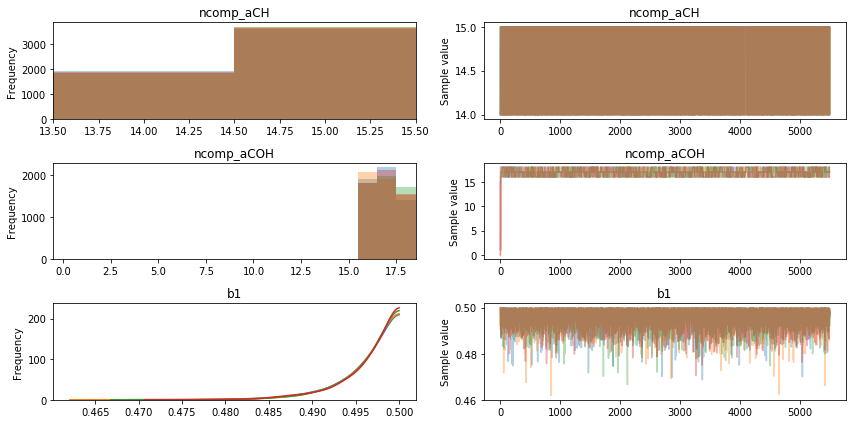

In [8]:
pm.traceplot(trace);

### Sparse model

However, there are problems doing inference on this model (lots of divergence)

In [9]:
with pm.Model() as m1:
    # Priors for unknown model parameters
    b1 = pm.Uniform('b1', lower=0.3, upper=0.5)
    ncomp_aCH = pm.Dirichlet('ncomp_aCH', a=np.ones(n)/n)
    ncomp_aCOH = pm.Dirichlet('ncomp_aCOH', a=np.ones(n)/n)

    aCH = aCH_.dot(ncomp_aCH)
    aCOH = aCOH_.dot(ncomp_aCOH)

    out = b1 * aCH + aCOH

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=out, tau=sigma, observed=Y)
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ncomp_aCOH_stickbreaking__, ncomp_aCH_stickbreaking__, b1_interval__]
100%|██████████| 3000/3000 [00:33<00:00, 88.41it/s]
There were 816 divergences after tuning. Increase `target_accept` or reparameterize.
There were 769 divergences after tuning. Increase `target_accept` or reparameterize.
There were 819 divergences after tuning. Increase `target_accept` or reparameterize.
There were 830 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


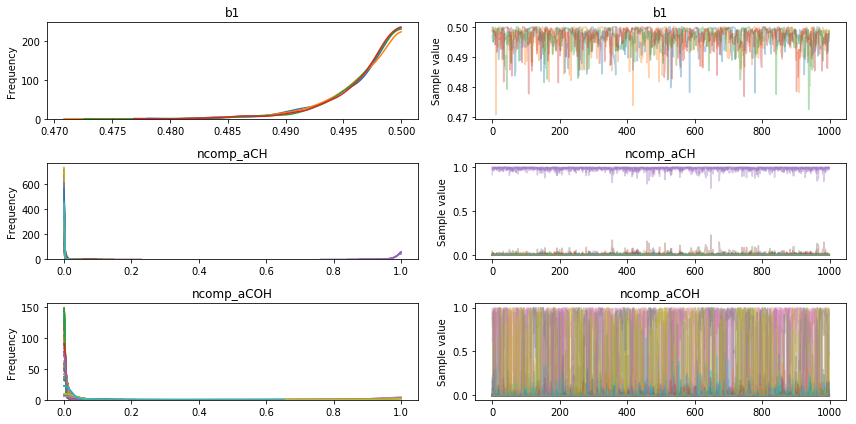

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b1,0.496557,0.003431,0.000105,4.896207e-01,0.499992,980.702225,1.000036
ncomp_aCH__0,0.000735,0.003225,0.000056,5.411298e-50,0.004155,3220.705314,0.999665
ncomp_aCH__1,0.000679,0.002736,0.000054,7.730233e-78,0.004025,2595.534761,1.001152
ncomp_aCH__2,0.000613,0.002825,0.000053,2.329331e-72,0.003420,3075.674039,0.999918
ncomp_aCH__3,0.000600,0.002709,0.000049,1.773499e-61,0.003475,2912.629974,1.001612
ncomp_aCH__4,0.000572,0.002421,0.000040,8.787489e-58,0.003101,3294.187218,1.000303
ncomp_aCH__5,0.000584,0.002681,0.000044,6.482632e-72,0.003240,3542.773622,0.999727
ncomp_aCH__6,0.000567,0.002360,0.000050,6.074154e-62,0.003189,2152.447487,1.000695
ncomp_aCH__7,0.000574,0.002401,0.000051,4.095825e-86,0.003226,2314.179503,0.999554
ncomp_aCH__8,0.000721,0.003067,0.000053,4.193191e-63,0.004095,2983.843514,0.999969


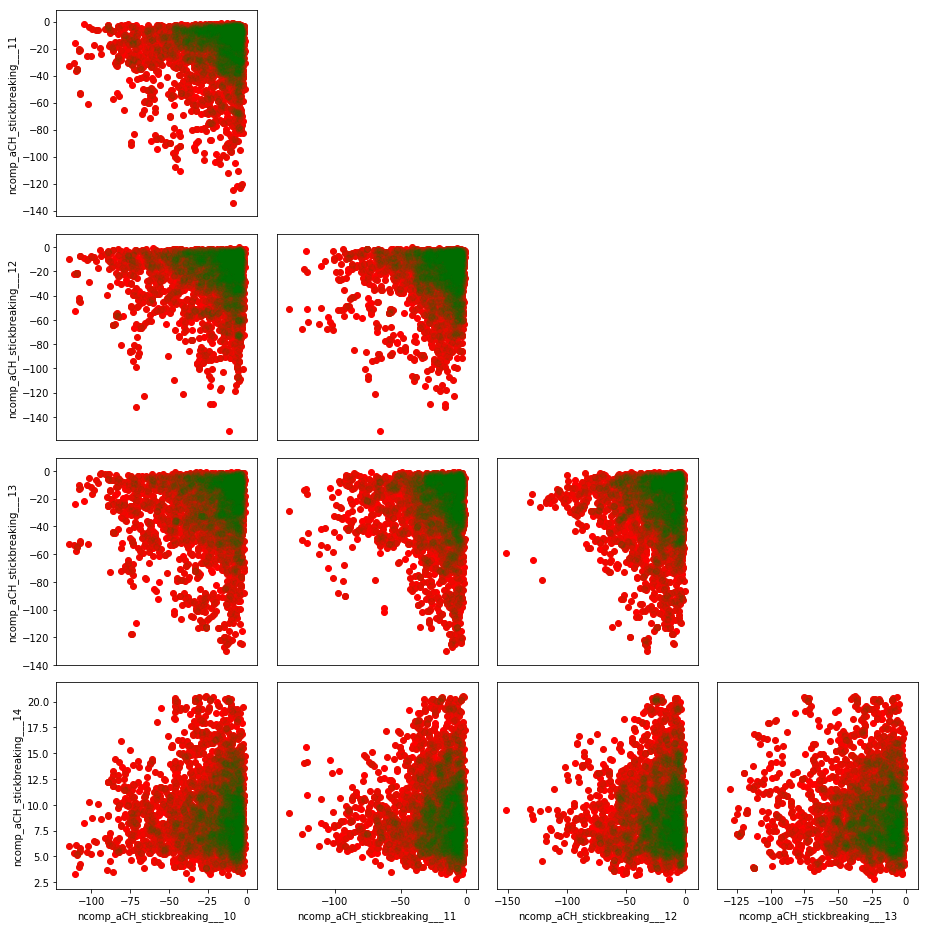

In [12]:
pm.pairplot(trace,
           sub_varnames=['ncomp_aCH_stickbreaking___%i'%i for i in np.arange(10, 15)],
           divergences=True,
           color='red', kwargs_divergence={'color':'green', 'alpha':.05});

### Reparameterized model

In [13]:
import theano.tensor as tt
Dirprior = 1./n # control the sparsity
with pm.Model() as m2:
    # Priors for unknown model parameters
    b1 = pm.Uniform('b1', lower=0.3, upper=0.5)

    beta1 = pm.Gamma('beta1', alpha=Dirprior, beta=1., shape=n)
    ncomp_aCH = pm.Deterministic('ncomp_aCH', beta1/tt.sum(beta1))
    beta2 = pm.Gamma('beta2', alpha=Dirprior, beta=1., shape=n)
    ncomp_aCOH = pm.Deterministic('ncomp_aCOH', beta2/tt.sum(beta2))

    aCH = aCH_.dot(ncomp_aCH)
    aCOH = aCOH_.dot(ncomp_aCOH)

    out = b1 * aCH + aCOH

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=out, tau=sigma, observed=Y)
    trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2_log__, beta1_log__, b1_interval__]
100%|██████████| 3000/3000 [00:42<00:00, 69.93it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


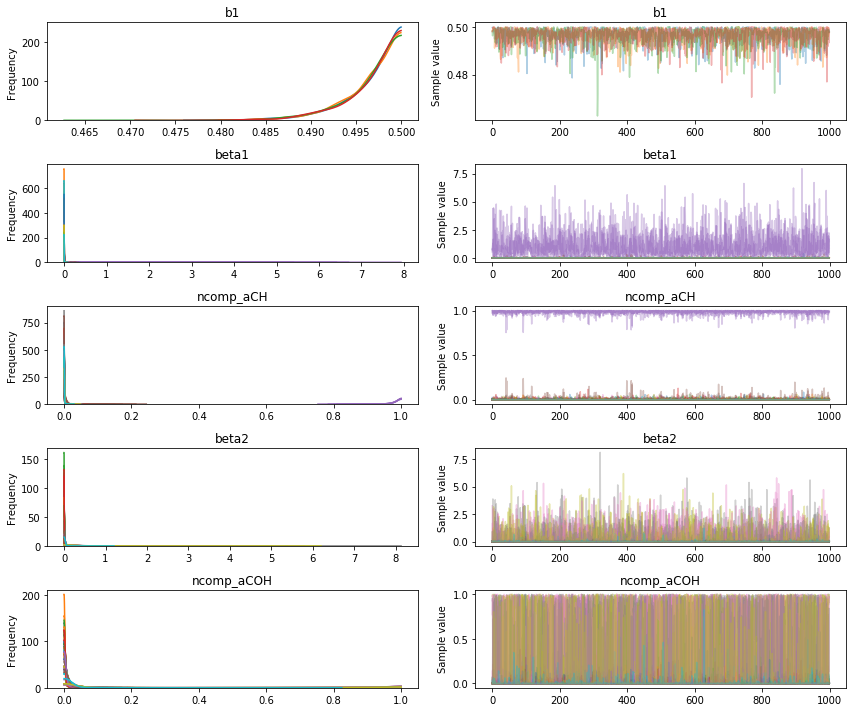

In [14]:
pm.traceplot(trace);

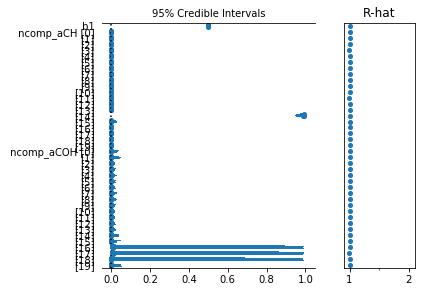

In [15]:
pm.forestplot(trace,varnames=['b1', 'ncomp_aCH', 'ncomp_aCOH']);